# Preprocessing Training and Modeling

In [1]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import matplotlib.pyplot as plt
import datetime

## Preprocessing and Understanding

In [2]:
df = pd.read_csv('fraudTrain.csv')

In [3]:
# Deleted first column since it was the same as the index
df = df.iloc[: , 1:]
# We are going to rename some columns for ease
df = df.rename(columns={'trans_date_trans_time':'date_time'})
# Drop any duplicates
df.drop_duplicates(inplace=True)

In [4]:
df.shape

(1296675, 22)

In [5]:
# Let's downsize the data for ease of speed
df = df.sample(frac=0.01)
df.shape

(12967, 22)

In [6]:
df.head()

,date_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
844251,2019-12-14 14:24:34,3577578023716568,fraud_Connelly-Carter,home,61.30,Debbie,Hughes,F,0182 Owens Burgs Suite 480,Diamond,...,41.0935,-81.0425,2644,"Engineer, biomedical",1983-08-25,26adc9780adf68d32f2806e7e24d9607,1355495074,41.182834,-80.598998,0
1073400,2020-03-22 06:33:04,4822367783500458,fraud_Smitham-Boehm,grocery_net,49.51,Christopher,Farrell,M,97070 Anderson Land,Haines City,...,28.0758,-81.5929,33804,Exercise physiologist,1991-01-01,02e371db409e3999b37e297a3e7b1f49,1363933984,27.454865,-81.846996,0
1035705,2020-03-05 07:38:39,4512828414983801773,fraud_Kutch-Hegmann,grocery_net,50.88,Monica,Cohen,F,864 Reynolds Plains,Uledi,...,39.8936,-79.7856,328,Tree surgeon,1983-07-25,a2db8ea2d74b5970267465073343cc1f,1362469119,39.880428,-80.729349,0
1142571,2020-04-20 23:57:09,2222157926772399,fraud_Rau-Grant,kids_pets,130.63,Amy,Garrett,F,6014 Thomas Throughway,Trenton,...,33.4235,-96.3398,2211,"Investment banker, operational",1987-02-26,d3a3fbb5187f2650287c335489edfb5e,1366502229,34.250078,-95.344471,0
269503,2019-05-13 10:44:33,30030380240193,fraud_Terry-Huel,shopping_net,95.43,William,Jenkins,M,50614 Kevin Point,Harper,...,30.2816,-99.2410,2395,"Pharmacist, community",1993-11-17,2ecaf4f9f576869f25389a393089217e,1336905873,30.301885,-100.135697,0


In [7]:
df.columns

Index(['date_time', 'cc_num', 'merchant', 'category', 'amt', 'first', 'last',
       'gender', 'street', 'city', 'state', 'zip', 'lat', 'long', 'city_pop',
       'job', 'dob', 'trans_num', 'unix_time', 'merch_lat', 'merch_long',
       'is_fraud'],
      dtype='object')

In [8]:
# No null data
df.isnull().sum()

date_time     0
cc_num        0
merchant      0
category      0
amt           0
first         0
last          0
gender        0
street        0
city          0
state         0
zip           0
lat           0
long          0
city_pop      0
job           0
dob           0
trans_num     0
unix_time     0
merch_lat     0
merch_long    0
is_fraud      0
dtype: int64

In [9]:
print(df['amt'].max())
print(df['amt'].min())

4976.59
1.0


Since there is a huge difference in the max and min values for the transaction amount, I will then scale this column to make the data more practical.

In [10]:
# We want to standardize the 'amt' column
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
amount = df['amt'].values
df['amt'] = sc.fit_transform(amount.reshape(-1, 1))
df['amt']

844251    -0.063860
1073400   -0.149753
1035705   -0.139772
1142571    0.441229
269503     0.184787
             ...   
682304    -0.286498
898375     0.066328
338451     0.038499
967983    -0.494202
935753    -0.407798
Name: amt, Length: 12967, dtype: float64

Everything in the 'amt' or Amount column looks like it has been scaled and so we will move onto the train and test split. While doing EDA, we found out that most of the columns are not correlated with wether or not the transaction is fraudulent. Therefore, we will create a new dataframe that focuses on the features we need. Additionally, it will save running time.

In [11]:
dfa = df[['amt', 'is_fraud']]
dft = df[['date_time', 'is_fraud']]

## Train Test Split - Time Series

The first step in creating an ARIMA model is checking if the series is stationary using the Dickey Fuller Test (ADF). The null hypothesis of the ADF test is that the time series is nonstationary. SO if the p-value of the test is less than the significance level (0.05), then we reject the null hypthesis and infer that the time series is stationary. If the p-value > 0.05, then we find the order of differencing.

In [12]:
from statsmodels.tsa.stattools import adfuller
from numpy import log

result = adfuller(dft.is_fraud)
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: -114.506069
p-value: 0.000000


Since P-value is greater than the significance level, let’s move on to see which is the best ARIMA order to use by using the auto_arima tool.

In [13]:
from pmdarima import auto_arima


model_arima= auto_arima(dft.is_fraud,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,
              suppress_warnings=True,stepwise=False,seasonal=False)

 ARIMA(0,0,0)(0,0,0)[0]             : AIC=-30364.463, Time=0.82 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=-30362.463, Time=3.13 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=-30360.463, Time=1.80 sec
 ARIMA(0,0,3)(0,0,0)[0]             : AIC=-30360.831, Time=3.51 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=-30362.463, Time=0.49 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=-30360.463, Time=3.65 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=-30358.463, Time=6.20 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=-30358.831, Time=4.61 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=-30360.463, Time=2.73 sec
 ARIMA(2,0,1)(0,0,0)[0]             : AIC=-30358.463, Time=2.92 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=-30356.463, Time=7.15 sec
 ARIMA(2,0,3)(0,0,0)[0]             : AIC=-30356.831, Time=3.63 sec
 ARIMA(3,0,0)(0,0,0)[0]             : AIC=-30360.896, Time=3.08 sec
 ARIMA(3,0,1)(0,0,0)[0]             : AIC=-30358.896, Time=3.55 sec
 ARIMA(3,0,2)(0,0,0)[0]             : AIC=-30356

In [14]:
from statsmodels.tsa.arima.model import ARIMA

series = dft.is_fraud
X = series
size = int(len(X) * 0.75)  
train, test = X[0:size], X[size:]
history = [x for x in train]
model = ARIMA(history, order=(0,0,0))
model_fit = model.fit()
print(model_fit.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 9725
Model:                          ARIMA   Log Likelihood               11571.539
Date:                Sat, 22 Oct 2022   AIC                         -23139.078
Time:                        10:35:42   BIC                         -23124.713
Sample:                             0   HQIC                        -23134.209
                               - 9725                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0054      9.566      0.001      1.000     -18.743      18.754
sigma2         0.0054      0.105      0.052      0.959      -0.200       0.211
Ljung-Box (L1) (Q):                   0.29   Jarque-

### Plot Arima

In [15]:
forecast_test = model_fit.forecast(len(test))
forecast_test.shape

(3242,)

In [16]:
print(forecast_test)

[0.00544487 0.00544487 0.00544487 ... 0.00544487 0.00544487 0.00544487]


In [17]:
test.shape

(3242,)

In [18]:
print(dft['date_time'][size:])

795393     2019-12-02 21:25:04
473118     2019-07-27 14:30:28
626797     2019-09-23 10:55:48
78197      2019-02-16 02:46:15
1139708    2020-04-20 03:17:08
                  ...         
682304     2019-10-18 12:43:19
898375     2019-12-26 13:07:12
338451     2019-06-09 11:31:21
967983     2020-01-26 10:41:26
935753     2020-01-06 23:43:35
Name: date_time, Length: 3242, dtype: object


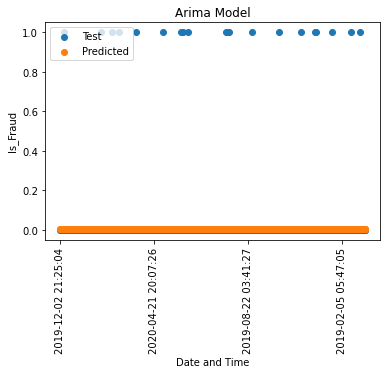

In [19]:
plt.scatter(dft['date_time'][size:], test, label="Test")
plt.scatter(dft['date_time'][size:], forecast_test, label="Predicted")
plt.xlabel('Date and Time')
plt.ylabel('Is_Fraud')
plt.legend(loc="upper left")
plt.xticks(np.arange(0, 3242, 1000), rotation = 90)
plt.title('Arima Model')
plt.show()

### Plot Residual

In [20]:
diff = test - forecast_test 

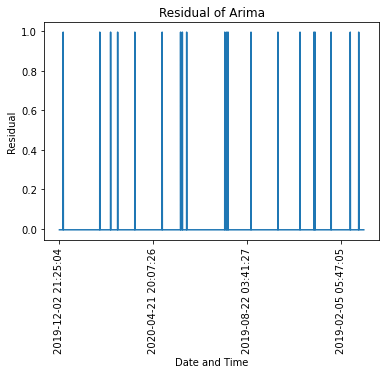

In [21]:
plt.plot(dft['date_time'][size:], diff)
plt.xticks(np.arange(0, 3242, 1000), rotation = 90)
plt.xlabel('Date and Time')
plt.ylabel('Residual')
plt.title('Residual of Arima')
plt.show()

In [22]:
from statistics import mean

avg = mean(diff)
print('The average of the residual is', avg)

The average of the residual is 0.0007241622430782345


Although the average of the residual is low, however, we have to consider that the majority of the data is nonfraudulent data. If we look at the Arima model, it did not predict a single fraudulent behavior when there was some. Let's feed the residual with  the random forest model (with other characteristics).

### Random Forest on Residuals

In [23]:
df.head()

,date_time,cc_num,merchant,category,amt,first,last,gender,street,city,...,lat,long,city_pop,job,dob,trans_num,unix_time,merch_lat,merch_long,is_fraud
844251,2019-12-14 14:24:34,3577578023716568,fraud_Connelly-Carter,home,-0.063860,Debbie,Hughes,F,0182 Owens Burgs Suite 480,Diamond,...,41.0935,-81.0425,2644,"Engineer, biomedical",1983-08-25,26adc9780adf68d32f2806e7e24d9607,1355495074,41.182834,-80.598998,0
1073400,2020-03-22 06:33:04,4822367783500458,fraud_Smitham-Boehm,grocery_net,-0.149753,Christopher,Farrell,M,97070 Anderson Land,Haines City,...,28.0758,-81.5929,33804,Exercise physiologist,1991-01-01,02e371db409e3999b37e297a3e7b1f49,1363933984,27.454865,-81.846996,0
1035705,2020-03-05 07:38:39,4512828414983801773,fraud_Kutch-Hegmann,grocery_net,-0.139772,Monica,Cohen,F,864 Reynolds Plains,Uledi,...,39.8936,-79.7856,328,Tree surgeon,1983-07-25,a2db8ea2d74b5970267465073343cc1f,1362469119,39.880428,-80.729349,0
1142571,2020-04-20 23:57:09,2222157926772399,fraud_Rau-Grant,kids_pets,0.441229,Amy,Garrett,F,6014 Thomas Throughway,Trenton,...,33.4235,-96.3398,2211,"Investment banker, operational",1987-02-26,d3a3fbb5187f2650287c335489edfb5e,1366502229,34.250078,-95.344471,0
269503,2019-05-13 10:44:33,30030380240193,fraud_Terry-Huel,shopping_net,0.184787,William,Jenkins,M,50614 Kevin Point,Harper,...,30.2816,-99.2410,2395,"Pharmacist, community",1993-11-17,2ecaf4f9f576869f25389a393089217e,1336905873,30.301885,-100.135697,0


In [24]:
# create a new dataframe from the residuals
df_rf = pd.DataFrame(diff)
df_rf = df_rf.rename(columns = {'is_fraud':'residual'})

In [25]:
df_rf['date_time'] = df['date_time'][size:]
df_rf['amt'] = df['amt'][size:]
df_rf['city_pop'] = df['city_pop'][size:]
df_rf['is_fraud'] = df['is_fraud'][size:]
df_rf.reset_index(drop=True)

,residual,date_time,amt,city_pop,is_fraud
0,-0.005445,2019-12-02 21:25:04,-0.501123,276002,0
1,-0.005445,2019-07-27 14:30:28,-0.014611,741,0
2,-0.005445,2019-09-23 10:55:48,-0.108883,3684,0
3,-0.005445,2019-02-16 02:46:15,-0.480869,11751,0
4,-0.005445,2020-04-20 03:17:08,-0.456391,207,0
...,...,...,...,...,...
3237,-0.005445,2019-10-18 12:43:19,-0.286498,21902,0
3238,-0.005445,2019-12-26 13:07:12,0.066328,84106,0
3239,-0.005445,2019-06-09 11:31:21,0.038499,4508,0
3240,-0.005445,2020-01-26 10:41:26,-0.494202,350,0


In [26]:
from sklearn.model_selection import train_test_split

X = df_rf[['amt', 'city_pop']]
y = df_rf['is_fraud']

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

In [28]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel

sel = SelectFromModel(RandomForestClassifier(n_estimators = 100))
sel.fit(X_train, y_train)

SelectFromModel(estimator=RandomForestClassifier())

In [29]:
sel.get_support()

array([ True, False])

This means that between transaction amount and city population, transaction amount is the best feature we should look at.

In [30]:
# It will return an Integer representing the number of features selected by the random forest

selected_feat= X_train.columns[(sel.get_support())]
len(selected_feat)

1

In [31]:
print(selected_feat)

Index(['amt'], dtype='object')


Seeing as transaction amount is the best feature to look at, we will do further analysis on transaction amount and the residuals from our arima model in the next section.

## Train Test Split - Amount

In [32]:
X = dfa.drop('is_fraud', axis = 1).values
y = dfa['is_fraud'].values

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state = 1)

### Decision Tree Classifier

In [38]:
from sklearn.tree import DecisionTreeClassifier

DT = DecisionTreeClassifier(max_depth = 4, criterion = 'entropy')
DT.fit(X_train, y_train)
dt_yhat = DT.predict(X_test)

In [39]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score

print('Accuracy score of the Decision Tree model is {}'.format(accuracy_score(y_test, dt_yhat)))
print('F1 score of the Decision Tree model is {}'.format(f1_score(y_test, dt_yhat)))
confusion_matrix(y_test, dt_yhat, labels = [0, 1])

Accuracy score of the Decision Tree model is 0.9950647748303516
F1 score of the Decision Tree model is 0.2


array([[3224,    1],
       [  15,    2]], dtype=int64)

Here, the first row represents positive and the second row represents negative. So, we have 3219 as true positive and 0 are false positive. We have 3219 that are successfully classified as a nonfraudulent transaction and 0 were falsely classified as nonfraudulent, but they were fraudulent. For the accuracy and F1 score, generally we want the score closer to 1. The accuracy score of the Decision Tree model is pretty good but the F1 score is alright.

### K-Nearest Neighbors

In [40]:
from sklearn.neighbors import KNeighborsClassifier

n = 7
KNN = KNeighborsClassifier(n_neighbors = n)
KNN.fit(X_train, y_train)
knn_yhat = KNN.predict(X_test)

In [41]:
print('Accuracy score of the K-Nearest Neighbors model is {}'.format(accuracy_score(y_test, knn_yhat)))
print('F1 score of the K-Nearest Neighbors model is {}'.format(f1_score(y_test, knn_yhat)))
confusion_matrix(y_test, knn_yhat, labels = [0, 1])

Accuracy score of the K-Nearest Neighbors model is 0.9947563232572486
F1 score of the K-Nearest Neighbors model is 0.2608695652173913


array([[3222,    3],
       [  14,    3]], dtype=int64)

### Logistic Regression

In [42]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression()
lr.fit(X_train, y_train)
lr_yhat = lr.predict(X_test)

In [43]:
print('Accuracy score of the Logistic Regression model is {}'.format(accuracy_score(y_test, lr_yhat)))
print('F1 score of the Logistic Regression model is {}'.format(f1_score(y_test, lr_yhat)))
confusion_matrix(y_test, lr_yhat, labels = [0, 1])

Accuracy score of the Logistic Regression model is 0.9938309685379395
F1 score of the Logistic Regression model is 0.0


array([[3222,    3],
       [  17,    0]], dtype=int64)

### Random Forest

In [44]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(max_depth = 4)
rf.fit(X_train, y_train)
rf_yhat = rf.predict(X_test)

In [45]:
print('Accuracy score of the Random Forest model is {}'.format(accuracy_score(y_test, rf_yhat)))
print('F1 score of the Random Forest model is {}'.format(f1_score(y_test, rf_yhat)))
confusion_matrix(y_test, rf_yhat, labels = [0, 1])

Accuracy score of the Random Forest model is 0.9950647748303516
F1 score of the Random Forest model is 0.2727272727272727


array([[3223,    2],
       [  14,    3]], dtype=int64)

### XGBoost

In [46]:
from xgboost import XGBClassifier

xgb = XGBClassifier(max_depth = 4)
xgb.fit(X_train, y_train)
xgb_yhat = xgb.predict(X_test)

In [47]:
print('Accuracy score of the XGBoost model is {}'.format(accuracy_score(y_test, xgb_yhat)))
print('F1 score of the XGBoost model is {}'.format(f1_score(y_test, xgb_yhat)))
confusion_matrix(y_test, xgb_yhat, labels = [0, 1])

Accuracy score of the XGBoost model is 0.9947563232572486
F1 score of the XGBoost model is 0.31999999999999995


array([[3221,    4],
       [  13,    4]], dtype=int64)

### Hybrid XGBoost Model - XGBoost and Random Forest Classifier

In [48]:
from xgboost import XGBRFClassifier

xgbrf = XGBRFClassifier()
xgbrf.fit(X_train, y_train)
xgbrf_yhat = xgb.predict(X_test)

In [49]:
print('Accuracy score of the XGBRF model is {}'.format(accuracy_score(y_test, xgbrf_yhat)))
print('F1 score of the XGBRF model is {}'.format(f1_score(y_test, xgbrf_yhat)))
confusion_matrix(y_test, xgbrf_yhat, labels = [0, 1])

Accuracy score of the XGBRF model is 0.9947563232572486
F1 score of the XGBRF model is 0.31999999999999995


array([[3221,    4],
       [  13,    4]], dtype=int64)

## Overall Scores

In [50]:
accuracy = [accuracy_score(y_test, dt_yhat), accuracy_score(y_test, knn_yhat), accuracy_score(y_test, lr_yhat), 
            accuracy_score(y_test, xgb_yhat), accuracy_score(y_test, xgbrf_yhat)]
f1 = [f1_score(y_test, dt_yhat), f1_score(y_test, knn_yhat), f1_score(y_test, lr_yhat), 
            f1_score(y_test, xgb_yhat), f1_score(y_test, xgbrf_yhat)]
names = ['DT', 'KNN', 'LR', 'XGB', 'XBGRF']

In [51]:
def scores(accuracy, f1, names):
    for i in range(0, 5):
        print('For', names[i])
        print('It has an accuracy score of', accuracy[i])
        print('And an F1 score of', f1[i])

In [52]:
scores(accuracy, f1, names)

For DT
It has an accuracy score of 0.9950647748303516
And an F1 score of 0.2
For KNN
It has an accuracy score of 0.9947563232572486
And an F1 score of 0.2608695652173913
For LR
It has an accuracy score of 0.9938309685379395
And an F1 score of 0.0
For XGB
It has an accuracy score of 0.9947563232572486
And an F1 score of 0.31999999999999995
For XBGRF
It has an accuracy score of 0.9947563232572486
And an F1 score of 0.31999999999999995


In [53]:
max(accuracy)

0.9950647748303516

In [54]:
max(f1)

0.31999999999999995

Decision Tree Classifier has the highest accuracy score but XGBoost and XGBoost/Random Forest has the highest F1 score. So how do we choose between the two?

### Conclusion

Remember that the F1 score is balancing precision and recall on the positive class while accuracy looks at correctly classified observations both positive and negative. That makes a big difference especially for the imbalanced problems where by default our model will be good at predicting true negatives and hence accuracy will be high. However, if you care equally about true negatives and true positives then accuracy is the metric you should choose. 

Since our dataset is naturally imbalanced, it will make our accuracy score really high by default. That is why we will care more about the F1 score in this case.

Therefore, the best model is the XGBoost and XGBRF which has the same accuracy and F1 score. We have an accuracy of 99.35% and a F1 score of 32.26%

### Using Random Forest on Residuals (In the Works)

In [55]:
X_test = df_rf['residual'][int(len(df_rf)*0.75):].values
X_train = df_rf['residual'][:int(len(df_rf)*0.75)].values
print(X_train.shape)
print(X_test.shape)

(2431,)
(811,)


In [56]:
y_test = df_rf['is_fraud'][int(len(df_rf)*0.75):].values
y_train = df_rf['is_fraud'][:int(len(df_rf)*0.75)].values

In [57]:
rf = RandomForestClassifier(max_depth = 4)
rf.fit(X_train.reshape(-1,1), y_train)
rf_yhat = rf.predict(X_test)

ValueError: Expected 2D array, got 1D array instead:
array=[-0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487  0.9945551
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487  0.9945551  -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487  0.9945551  -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
  0.9945551  -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
  0.9945551  -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
  0.9945551  -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487 -0.00544487
 -0.00544487].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

I tried to use a random forest on the residual but it did not work. I wonder if it had something to do with the Arima model since it did poorly in predicting if the work is fraudlent or not. So when I tried to do a random forest with other features, it did not go as planned.